Work in Progress. Will be updated by Friday. Zheyu Ni

This file cleans the Airbnb data. 
1. deleted $ sign and comma in price.
2. visualize price distribution base on different features
3. Price range (0, 800) covers 95\% of the listings
4. create a dummy for the listing without review data
5. check how many listings have hotel/motel in name and agree with their room_type

The remaing data file contains \% of the raw data

In [215]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import date
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.cluster import KMeans

In [216]:
df = pd.read_csv('../listings_mar2023_w_hotspot_0.3milebins.csv')


In [217]:
#data cleaning. Price data has $ sign. The following code extracts the number
df['price'] = df['price'].replace({r'\$':''},regex = True).replace({r',':''},regex = True).astype('float')
df.price

0        399.0
1         46.0
2        408.0
3         80.0
4         55.0
         ...  
40142    150.0
40143     66.0
40144     70.0
40145    188.0
40146     68.0
Name: price, Length: 40147, dtype: float64

In [218]:
print(df['room_type'].value_counts())

Entire home/apt    28714
Private room       10335
Shared room          695
Hotel room           403
Name: room_type, dtype: int64


In [219]:
df_practice = df.copy()
df_practice['name'] = df_practice['name'].str.lower()
df_practice.loc[df_practice['name'].str.contains('motel',regex=False) == True, 'room_type'] = 'Hotel room'
df_practice.loc[df_practice['name'].str.contains('hotel',regex=False) == True, 'room_type'] = 'Hotel room'
df['room_type'] = df_practice['room_type']
#df_practice.dropna()

In [220]:
print(df['room_type'].value_counts())

Entire home/apt    28714
Private room       10335
Shared room          695
Hotel room           403
Name: room_type, dtype: int64


In [221]:
df_practice.loc[df_practice['name'].str.contains('hotel',regex=False) == True].sample(2)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hotspot_from_listings,hotspot_from_reviews,hotspot_from_reviews_per_month
40083,40083,755237500802553530,https://www.airbnb.com/rooms/755237500802553530,20230307175359,2023-03-08,city scrape,affordable hotel style unit,"""LA Suites is nestled in the heart of Beverly ...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,...,NaN,t,56,56,0,0,NaN,1.0,0.023992,0.167769
39850,39850,751483800366943901,https://www.airbnb.com/rooms/751483800366943901,20230307175359,2023-03-08,city scrape,large hotel style suite,LA Suites is nestled in the heart of Beverly H...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,...,NaN,t,54,54,0,0,NaN,1.0,0.001440,0.039506


In [222]:
df.head(2)

#columns that are interesting:
# latitude
# longitude
# room_type
# property_type
# accommodates
# bathrooms_text
# number_of_reviews
# first_review
# last_reviews
# reviews_per_month


,Unnamed: 0,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,...,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hotspot_from_listings,hotspot_from_reviews,hotspot_from_reviews_per_month
0,0,777451666060243581,https://www.airbnb.com/rooms/777451666060243581,20230307175359,2023-03-07,city scrape,Family oriented home,Relax with the whole family at this peaceful p...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,...,NaN,f,1,0,1,0,NaN,0.018519,0.0,0.0
1,1,698097753730921190,https://www.airbnb.com/rooms/698097753730921190,20230307175359,2023-03-07,city scrape,方便易居驿站,NaN,NaN,https://a0.muscache.com/pictures/d5afff58-d576...,...,NaN,f,4,0,4,0,0.86,0.055556,0.0,0.0


In [223]:
#column_names =[df.columns,df.dtypes]
#list(column_names)

df.price[0:10]

0    399.0
1     46.0
2    408.0
3     80.0
4     55.0
5     60.0
6     55.0
7     39.0
8     39.0
9    199.0
Name: price, dtype: float64

In [224]:
df.price.max()

1995.0

In [225]:
df = df[df['price'] < 1999]

In [226]:
df.price.max()

1995.0

In [227]:
df_priv = df[df['room_type']=='Private room'].copy()
df_homeapt = df[df['room_type']=='Entire home/apt'].copy()
df_share = df[df['room_type']=='Shared room'].copy()
df_hotel = df[df['room_type']=='Hotel room'].copy()

In [228]:
df_priv['latitude'].min()

33.33956

In [229]:
X = df[['latitude','longitude']]

In [230]:
## a loop to record inertias
inertias = []
max_clusters = 30
for k in range(1,max_clusters):
    kmeans = KMeans(k,
                    n_init='auto')
    kmeans.fit(X)
    
    ## you can get the inertia from a fit KMeans object
    ## with .inertia_
    inertias.append(kmeans.inertia_)

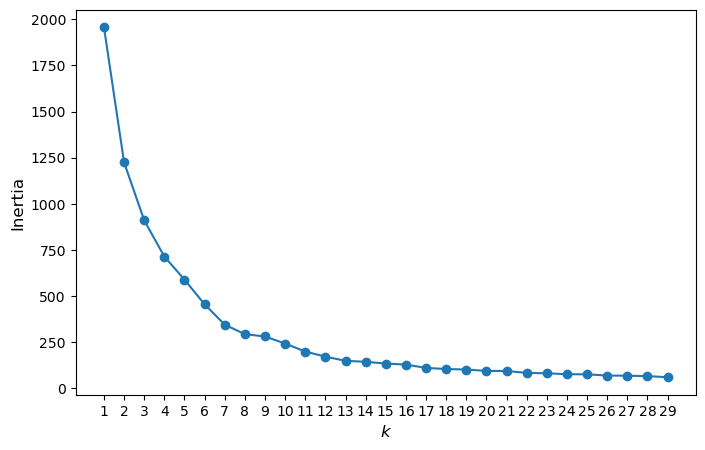

In [231]:
plt.figure(figsize=(8,5))

plt.plot(range(1,max_clusters), inertias, '-o')

plt.xlabel("$k$", fontsize=12)
plt.ylabel("Inertia", fontsize=12)

plt.xticks(range(1,max_clusters),fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [232]:
num_of_clusters = 15
print(inertias[num_of_clusters-1])

134.56861128214643


In [233]:
num_of_clusters = 100
## Make a KMeans object
kmeans = KMeans(num_of_clusters,
                n_init='auto')

## Fit the kmeans object
kmeans.fit(X)

## get the clusters
clusters = kmeans.fit_predict(X)

In [234]:
X

,latitude,longitude
0,34.43925,-118.44409
1,34.04848,-117.76887
2,33.73842,-118.39580
3,33.74842,-118.31100
4,33.73928,-118.29911
...,...,...
40142,34.05867,-118.38515
40143,33.91942,-118.20913
40144,33.91942,-118.20913
40145,34.04319,-118.25454


In [235]:
clusters.min()

0

In [236]:
kmeans.cluster_centers_

array([[  34.17980069, -118.52121504],
       [  34.1269134 , -118.07048491],
       [  34.05892822, -118.29642782],
       [  33.77528364, -118.18360481],
       [  34.05026261, -118.43652049],
       [  33.89482768, -118.2997316 ],
       [  34.6709896 , -118.21766798],
       [  34.0933465 , -117.7455547 ],
       [  34.1556886 , -118.40246268],
       [  33.35136134, -118.33345915],
       [  33.9835977 , -117.90742196],
       [  34.04889162, -118.72549344],
       [  34.14323358, -118.25446096],
       [  34.09518137, -118.34711079],
       [  34.39390391, -118.55696327],
       [  33.98155255, -118.46039135],
       [  34.03439042, -118.37280751],
       [  33.82497945, -118.37314733],
       [  33.92572381, -118.12425182],
       [  34.11767175, -118.18149596],
       [  34.04881085, -118.25461978],
       [  33.93616258, -118.35088151],
       [  34.06822304, -117.93894008],
       [  34.62557081, -117.81319532],
       [  34.16479567, -118.61723551],
       [  34.59605651, -1

C:\Users\Ricky\AppData\Local\Temp\ipykernel_3136\2905480532.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cl'] = clusters


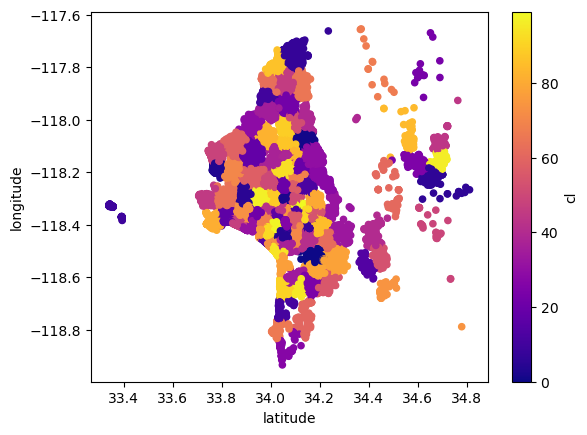

In [237]:
#Getting unique labels
X['cl'] = clusters
X.plot.scatter('latitude', 'longitude', c='cl', colormap='plasma')
plt.show()

In [238]:
df.shape, X.shape

((40147, 79), (40147, 3))

In [239]:
df.loc[:,"cluster_num"] = kmeans.labels_

In [240]:
df.cluster_num

0        40
1        86
2        81
3        45
4        45
         ..
40142    26
40143    58
40144    58
40145    20
40146    89
Name: cluster_num, Length: 40147, dtype: int32

In [241]:
df['hotness_in_cluster_by_num_of_listings'] = 0
df['hotness_in_cluster_by_num_of_reviews'] = 0
df['hotness_in_cluster_by_num_of_reviews_per_month'] = 0


for i in np.arange(0,num_of_clusters):        
    df.loc[df['cluster_num'] == i, 'hotness_in_cluster_by_num_of_listings'] = df[df['cluster_num'] == i]['hotspot_from_listings'].mean()
    df.loc[df['cluster_num'] == i, 'hotness_in_cluster_by_num_of_reviews'] = df[df['cluster_num'] == i]['hotspot_from_reviews'].mean()
    df.loc[df['cluster_num'] == i, 'hotness_in_cluster_by_num_of_reviews_per_month'] = df[df['cluster_num'] == i]['hotspot_from_reviews'].mean()

In [251]:
df.to_csv('../listings_mar2023_w_hotspot_0.3milebins_w_100clusters_identification.csv')

In [242]:
df[['cluster_num','hotspot_from_listings']]

,cluster_num,hotspot_from_listings
0,40,0.018519
1,86,0.055556
2,81,0.129630
3,45,0.037037
4,45,0.037037
...,...,...
40142,26,1.000000
40143,58,0.097222
40144,58,0.097222
40145,20,0.041667


In [243]:
df.sample()

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hotspot_from_listings,hotspot_from_reviews,hotspot_from_reviews_per_month,cluster_num,hotness_in_cluster_by_num_of_listings,hotness_in_cluster_by_num_of_reviews,hotness_in_cluster_by_num_of_reviews_per_month
3221,3221,3368750,https://www.airbnb.com/rooms/3368750,20230307175359,2023-03-08,city scrape,Best Kept Secret in Los Angeles,This private SMOKE FREE room is located walkin...,Walking distance from the LA Concert Forum.,https://a0.muscache.com/pictures/69129699/cc5c...,...,1,0,0.27,0.018519,0.0,0.0,21,0.030926,0.00256,0.00256


In [250]:
df[df['hotness_in_cluster_by_num_of_reviews'] > 0.05]

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hotspot_from_listings,hotspot_from_reviews,hotspot_from_reviews_per_month,cluster_num,hotness_in_cluster_by_num_of_listings,hotness_in_cluster_by_num_of_reviews,hotness_in_cluster_by_num_of_reviews_per_month
52,52,45195301,https://www.airbnb.com/rooms/45195301,20230307175359,2023-03-08,previous scrape,Large Rooms - near Downtown Long Beach -Queen ...,na,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,...,1,0,NaN,0.018519,0.000000,0.000000,3,0.082390,0.083653,0.083653
116,116,53218052,https://www.airbnb.com/rooms/53218052,20230307175359,2023-03-08,city scrape,Orleans in LA,Keep it simple at this peaceful and centrally-...,Centrally located 5 minutes to downtown LA,https://a0.muscache.com/pictures/67a0cd9e-b393...,...,1,0,0.33,0.018519,0.000000,0.000000,20,0.155375,0.085914,0.085914
146,146,32287827,https://www.airbnb.com/rooms/32287827,20230307175359,2023-03-08,previous scrape,Baewatch,Coastal property,NaN,https://a0.muscache.com/pictures/00befe71-1d88...,...,1,0,NaN,0.314815,0.008637,0.005395,20,0.155375,0.085914,0.085914
228,228,27226242,https://www.airbnb.com/rooms/27226242,20230307175359,2023-03-08,previous scrape,Cozy little rooms,Nice,NaN,https://a0.muscache.com/pictures/6721ad4c-a327...,...,1,0,NaN,0.277778,0.408829,0.557431,20,0.155375,0.085914,0.085914
264,264,762404121562830576,https://www.airbnb.com/rooms/762404121562830576,20230307175359,2023-03-09,city scrape,Private Master Bedroom w/ Spectacular City Views!,Private bedroom in shared apartment. Perfect f...,"Discover art, music, and culinary in the heart...",https://a0.muscache.com/pictures/3973d6c0-9dfa...,...,2,0,1.73,0.277778,0.408829,0.557431,20,0.155375,0.085914,0.085914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40071,40071,22358136,https://www.airbnb.com/rooms/22358136,20230307175359,2023-03-09,city scrape,King Skyline · King Skyline - Beautiful Hotel ...,THE SECRET TO A GOOD TIME IN LA? IT’S ALL IN T...,If you want to experience downtown L.A. in all...,https://a0.muscache.com/pictures/prohost-api/H...,...,7,5,8.03,0.055556,0.486084,0.323877,20,0.155375,0.085914,0.085914
40118,40118,32166487,https://www.airbnb.com/rooms/32166487,20230307175359,2023-03-09,city scrape,Accessible Hotel Room in DTLA - ADA Listing,"<b>The space</b><br />King Bed, 310 Square Fee...",If you want to experience downtown L.A. in all...,https://a0.muscache.com/pictures/prohost-api/H...,...,7,5,0.91,0.055556,0.486084,0.323877,20,0.155375,0.085914,0.085914
40122,40122,683937661806475422,https://www.airbnb.com/rooms/683937661806475422,20230307175359,2023-03-08,city scrape,Guest Room with 1 Queen Bed at Hotel Figueroa,Welcome to The Hotel Figueroa! <br /> <br /> A...,▶Landmarks <br />• In Downtown Los Angeles <br...,https://a0.muscache.com/pictures/prohost-api/H...,...,0,0,NaN,0.013889,0.000000,0.000000,20,0.155375,0.085914,0.085914
40136,40136,13762917,https://www.airbnb.com/rooms/13762917,20230307175359,2023-03-08,city scrape,"Huge 2-Bed/2-Bath near Ace Hotel, Staples & LACC",We have significantly reduced prices for exten...,Located in the heart of downtown LA's Theatre ...,https://a0.muscache.com/pictures/prohost-api/H...,...,0,0,2.20,0.027778,0.085413,0.038288,20,0.155375,0.085914,0.085914


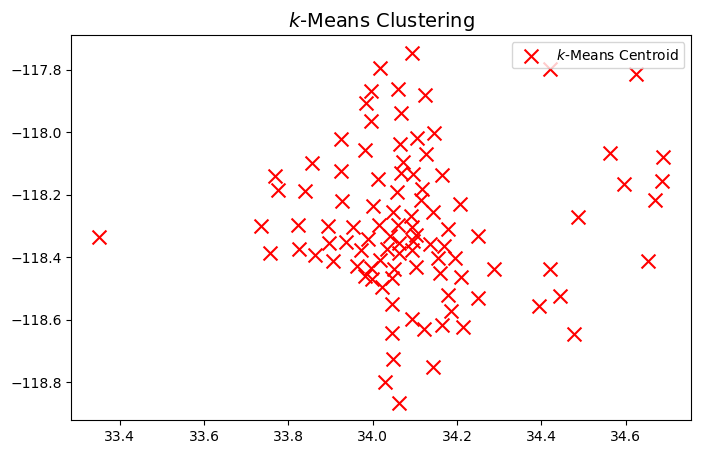

In [246]:
plt.figure(figsize=(8,5))

# plt.scatter(X[clusters==0,0], X[clusters==0,1], c='b', label="$k$-Means Cluster 0")
# plt.scatter(X[clusters==1,0], X[clusters==1,1], c='green', marker='v', label="$k$-Means Cluster 1")
# plt.scatter(X[clusters==2,0], X[clusters==2,1], c='k', marker='+', s=100, label="$k$-Means Cluster 2")

## You can get the centers with cluster_centers_
plt.scatter(kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], 
            c='r', marker='x', s=100, label='$k$-Means Centroid')


plt.legend(fontsize=10)
plt.title("$k$-Means Clustering", fontsize=14)

plt.show()

